# **Data Preprocessing**

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.float_format = '{:,.2f}'.format

## Data understanding

In [2]:
df = pd.read_csv(r"D:\accredian\data\Fraud.csv")
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,"9,839.64",C1231006815,"170,136.00","160,296.36",M1979787155,0.00,0.00,0,0
1,1,PAYMENT,"1,864.28",C1666544295,"21,249.00","19,384.72",M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,"21,182.00",0.00,1,0
4,1,PAYMENT,"11,668.14",C2048537720,"41,554.00","29,885.86",M1230701703,0.00,0.00,0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [4]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,"6,362,620.00","6,362,620.00","6,362,620.00","6,362,620.00","6,362,620.00","6,362,620.00","6,362,620.00","6,362,620.00"
mean,243.40,"179,861.90","833,883.10","855,113.67","1,100,701.67","1,224,996.40",0.00,0.00
std,142.33,"603,858.23","2,888,242.67","2,924,048.50","3,399,180.11","3,674,128.94",0.04,0.00
min,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,156.00,"13,389.57",0.00,0.00,0.00,0.00,0.00,0.00
50%,239.00,"74,871.94","14,208.00",0.00,"132,705.66","214,661.44",0.00,0.00
75%,335.00,"208,721.48","107,315.18","144,258.41","943,036.71","1,111,909.25",0.00,0.00
max,743.00,"92,445,516.64","59,585,040.37","49,585,040.37","356,015,889.35","356,179,278.92",1.00,1.00


In [5]:
# check missing values
df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [6]:
# check dupliated_values
df.duplicated().sum()

np.int64(0)

## **Feature Engineering**

**orig_balance_diff** checks whether the sender’s balance update follows basic accounting
(oldbalanceOrg − amount = newbalanceOrig).
Values close to 0 indicate normal behavior; large deviations indicate suspicious activity.

**dest_balance_diff** checks whether the receiver’s balance is correctly credited
(oldbalanceDest + amount = newbalanceDest).
This feature is computed only for non-merchant destinations; a large negative value means the transferred money did not reach the receiver, which is a strong fraud signal in this dataset.

In [7]:
#Create ismerchant col
df['isMerchant'] = df['nameDest'].str.startswith('M').astype(int)

#sender  balance diff
df['orig_balance_diff'] = df['oldbalanceOrg'] - df['newbalanceOrig'] - df['amount']

#receiver balance diff
df['dest_balance_diff'] = np.where(
    df['isMerchant'] == 0,
    df['newbalanceDest'] - df['oldbalanceDest'] - df['amount'],
    0
)

In [8]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,isMerchant,orig_balance_diff,dest_balance_diff
0,1,PAYMENT,"9,839.64",C1231006815,"170,136.00","160,296.36",M1979787155,0.00,0.00,0,0,1,0.00,0.00
1,1,PAYMENT,"1,864.28",C1666544295,"21,249.00","19,384.72",M2044282225,0.00,0.00,0,0,1,-0.00,0.00
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0,0,0.00,-181.00
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,"21,182.00",0.00,1,0,0,0.00,"-21,363.00"
4,1,PAYMENT,"11,668.14",C2048537720,"41,554.00","29,885.86",M1230701703,0.00,0.00,0,0,1,0.00,0.00


## **outlier detction**

*Transaction amount is highly right-skewed. Since large values carry strong fraud signals, outliers are not removed; instead, a log transformation is applied to reduce skewness while preserving fraud-relevant information.*

In [9]:
df['log_amount'] = np.log1p(df["amount"])

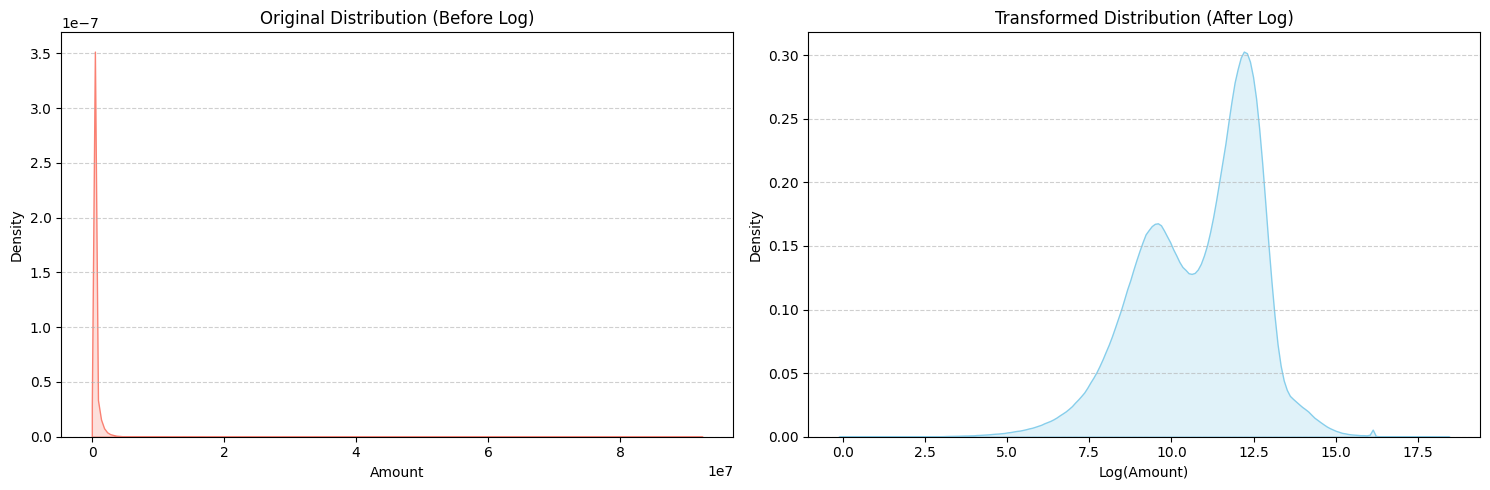

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 2. Plot Original Distribution (Before)
sns.kdeplot(data=df, x="amount", fill=True, color='salmon', bw_adjust=0.5, ax=axes[0])
axes[0].set_title('Original Distribution (Before Log)')
axes[0].set_xlabel("Amount")
axes[0].grid(True, axis='y', linestyle='--', alpha=0.6)

# 3. Plot Transformed Distribution (After)
sns.kdeplot(data=df, x="log_amount", fill=True, color='skyblue', bw_adjust=0.5, ax=axes[1])
axes[1].set_title('Transformed Distribution (After Log)')
axes[1].set_xlabel("Log(Amount)")
axes[1].grid(True, axis='y', linestyle='--', alpha=0.6)

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

## **Multi Colinearity**

using VIF-->How well this column can be predicted using all other columns together.

In [11]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_num = df.select_dtypes(include=['float64', 'int64']).drop(columns=['isFraud', 'isFlaggedFraud'])

vif = pd.DataFrame()
vif['feature'] = X_num.columns
vif['VIF'] = [variance_inflation_factor(X_num.values, i) for i in range(X_num.shape[1])]


d:\accredian\venv\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [12]:
vif

,feature,VIF
0,step,3.84
1,amount,inf
2,oldbalanceOrg,inf
3,newbalanceOrig,inf
4,oldbalanceDest,"240,862.65"
5,newbalanceDest,"282,985.15"
6,isMerchant,2.50
7,orig_balance_diff,inf
8,dest_balance_diff,"3,734.61"
9,log_amount,4.31


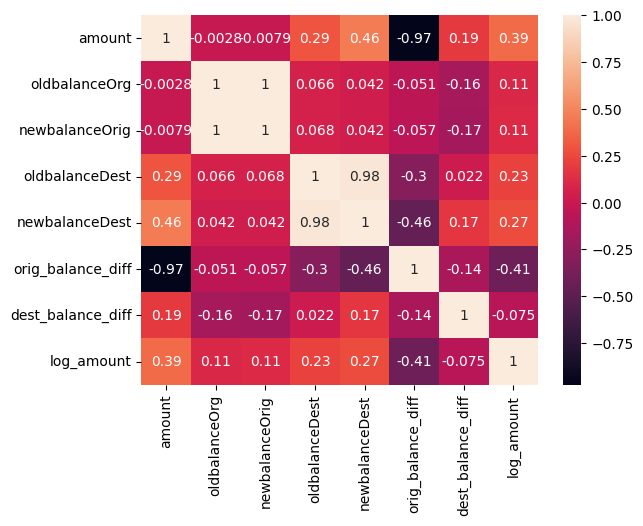

In [13]:
corr_matrix = df[[ 'amount','oldbalanceOrg', 'newbalanceOrig',
      'oldbalanceDest', 'newbalanceDest', 'orig_balance_diff',
       'dest_balance_diff', 'log_amount']].corr()

# Create basic heatmap
sns.heatmap(corr_matrix,annot=True)
plt.show()

In [14]:
df["isFraud"].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

# Training Explicitly

In [80]:
keep_cols = [
    'step',
    'type',
    'isMerchant',
    'orig_balance_diff',
    'dest_balance_diff',
    'log_amount',
    'isFraud'
]
df_model = df[keep_cols].copy()

In [81]:
# ------------------------------
# 2. ENCODE CATEGORICAL COLUMN
# ------------------------------

df_model = pd.get_dummies(
    df_model,
    columns=['type'],
    drop_first=True
)

# ------------------------------
# 3. DEFINE X AND y
# ------------------------------

X = df_model.drop(columns=['isFraud'])
y = df_model['isFraud']

# ------------------------------
# 4. TRAIN–TEST SPLIT (STRATIFIED)
# ------------------------------

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Before sampling:")
print(y_train.value_counts())

Before sampling:
isFraud
0    5083526
1       6570
Name: count, dtype: int64


In [87]:
# ------------------------------
# 5. SCALE NUMERICAL FEATURES
# ------------------------------

scaler = MinMaxScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[X.columns] = scaler.fit_transform(X_train)
X_test_scaled[X.columns] = scaler.transform(X_test)

In [94]:

# ------------------------------
# 6. UNDERSAMPLE (TRAINING DATA ONLY)
# ------------------------------
from imblearn.over_sampling import SMOTE

smote = SMOTE(
    sampling_strategy='auto',
    random_state=42,
    k_neighbors=5
)

X_train_bal, y_train_bal = smote.fit_resample(
    X_train_scaled,
    y_train
)

print("\nAfter SMOTE:")
print(y_train_bal.value_counts())


After SMOTE:
isFraud
0    5083526
1    5083526
Name: count, dtype: int64


In [151]:
# ------------------------------
# 7. TRAIN LOGISTIC REGRESSION
# ------------------------------

lr = LogisticRegression(
    max_iter=1000,
    solver='lbfgs',
    class_weight={0:1 , 1:20}
)

lr.fit(X_train_bal, y_train_bal)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*","{0: 1, 1: 20}"
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For

In [152]:
lr.score(X_train_bal, y_train_bal)

0.7826194849795202

In [153]:
# ------------------------------
# 8. EVALUATE ON ORIGINAL TEST DATA
# ------------------------------

y_pred = lr.predict(X_test_scaled)
y_proba = lr.predict_proba(X_test_scaled)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

print("ROC-AUC:", roc_auc_score(y_test, y_proba))



Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.5656    0.7225   1270881
           1     0.0030    1.0000    0.0059      1643

    accuracy                         0.5662   1272524
   macro avg     0.5015    0.7828    0.3642   1272524
weighted avg     0.9987    0.5662    0.7216   1272524

ROC-AUC: 0.9030552666063743


In [154]:
from sklearn.metrics import confusion_matrix

# Get predictions on test data
y_pred = lr.predict(X_test_scaled)

# Confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Precision & Recall
precision = tp / (tp + fp)
recall = tp / (tp + fn)

# Print explanation
print("PRECISION")
print(f"Actual fraud correctly predicted (TP): {tp}")
print(f"Normal cases wrongly predicted as fraud (FP): {fp}")
print(f"Precision = TP / (TP + FP) = {tp} / ({tp} + {fp}) = {precision:.4f}")
print()
print("Explanation:")
print(f"There are {tp + fn} actual fraud cases, but the model predicts fraud for {tp + fp} cases.")
print(f"Out of these, {fp} are actually normal transactions falsely predicted as fraud.")
print()
print("-" * 50)

print("RECALL")
print(f"Actual fraud correctly predicted (TP): {tp}")
print(f"Fraud cases missed by the model (FN): {fn}")
print(f"Recall = TP / (TP + FN) = {tp} / ({tp} + {fn}) = {recall:.4f}")
print()
print("Explanation:")
print(f"Out of {tp + fn} real fraud cases, the model successfully catches {tp} frauds")
print(f"and misses only {fn} fraud cases.")


PRECISION
Actual fraud correctly predicted (TP): 1643
Normal cases wrongly predicted as fraud (FP): 552077
Precision = TP / (TP + FP) = 1643 / (1643 + 552077) = 0.0030

Explanation:
There are 1643 actual fraud cases, but the model predicts fraud for 553720 cases.
Out of these, 552077 are actually normal transactions falsely predicted as fraud.

--------------------------------------------------
RECALL
Actual fraud correctly predicted (TP): 1643
Fraud cases missed by the model (FN): 0
Recall = TP / (TP + FN) = 1643 / (1643 + 0) = 1.0000

Explanation:
Out of 1643 real fraud cases, the model successfully catches 1643 frauds
and misses only 0 fraud cases.


In [91]:
# ------------------------------
# 9. FEATURE IMPORTANCE
# ------------------------------

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'coefficient': lr.coef_[0]
}).sort_values(by='coefficient', key=abs, ascending=False)

print("\nTop Features:")
print(feature_importance.head(10))


Top Features:
             feature  coefficient
3  dest_balance_diff      -527.96
2  orig_balance_diff       389.40
8      type_TRANSFER         9.94
5      type_CASH_OUT         9.00
4         log_amount         5.64
6         type_DEBIT        -3.29
0               step         2.14
1         isMerchant        -0.97
7       type_PAYMENT        -0.97


In [121]:
y_train_bal_pred = lr.predict(X_train_bal)
print(classification_report(y_train_bal, y_train_bal_pred, digits=4))


              precision    recall  f1-score   support

           0     0.9503    0.9109    0.9302   5083526
           1     0.9145    0.9524    0.9330   5083526

    accuracy                         0.9316  10167052
   macro avg     0.9324    0.9316    0.9316  10167052
weighted avg     0.9324    0.9316    0.9316  10167052



# **Pipeline**

* nameOrig          → ID, no signal

* nameDest          → ID (merchant info already captured by isMerchant)

* isFlaggedFraud    → rule-based label leakage

* oldbalanceOrg     → redundant

* newbalanceOrig   → redundant

* oldbalanceDest   → redundant

* newbalanceDest   → redundant

* amount            → replaced by log_amount

In [15]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,isMerchant,orig_balance_diff,dest_balance_diff,log_amount
0,1,PAYMENT,"9,839.64",C1231006815,"170,136.00","160,296.36",M1979787155,0.00,0.00,0,0,1,0.00,0.00,9.19
1,1,PAYMENT,"1,864.28",C1666544295,"21,249.00","19,384.72",M2044282225,0.00,0.00,0,0,1,-0.00,0.00,7.53
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0,0,0.00,-181.00,5.20
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,"21,182.00",0.00,1,0,0,0.00,"-21,363.00",5.20
4,1,PAYMENT,"11,668.14",C2048537720,"41,554.00","29,885.86",M1230701703,0.00,0.00,0,0,1,0.00,0.00,9.36


In [16]:
# Categorical columns
cat_features = ["type"]

#numerical features
num_features = [
    'step',
    'isMerchant',
    'orig_balance_diff',
    'dest_balance_diff',
    'log_amount'
]

In [17]:
# Drop Columns
drop_cols = [
    'nameOrig', 'nameDest',
    'oldbalanceOrg', 'newbalanceOrig',
    'oldbalanceDest', 'newbalanceDest',
    'amount', 'isFlaggedFraud'
]

df_model = df.drop(columns=drop_cols)

In [19]:
df_model.to_csv(r"D:\accredian\data\cleaned_fraud.csv")

In [20]:
# building preprocessing pipeline
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

In [21]:
#MinMax Scaler
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])
#OneHotEncoder
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

#build Column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ]
)

In [22]:
# split the dataset into train test
from sklearn.model_selection import train_test_split

X = df_model.drop(columns=['isFraud'])
y = df_model['isFraud']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [ ]:
#Full Model pipeline
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import  RandomOverSampler
#from imblearn.pipeline import Pipeline
      
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
     ('undersampler', RandomOverSampler(random_state=42)),
    ('classifier', LogisticRegression(
        max_iter=1000,
        class_weight={0:70 , 1:60},
        solver='lbfgs'
    ))
])

In [61]:
model

,steps,"[('preprocessor', ...), ('undersampler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sparse matrices,these will be stacked as a sparse matrix if the overall density islower than this value. Use ``sparse_threshold=0`` to always returndense. When the transformed output consists of all dense data, thestacked result will be dense, and this keyword will be ignored.",0.3
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None
,"transformer_weights transformer_weights: dict, default=NoneMultiplicative weights for features per transformer. The output of thetransformer is multiplied by these weights. Keys are transformer names,values the weights.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each transformer will beprinted as it is completed.",False
,"verbose_feature_names_out verbose_feature_names_out: bool, str or Callable[[str, str], str], default=True- If True, :meth:`ColumnTransformer.get_feature_names_out` will prefix all feature names with the name of the transformer that generated that feature. It is equivalent to setting `verbose_feature_names_out=""{transformer_name}__{feature_name}""`.- If False, :meth:`ColumnTransformer.get_feature_names_out` will not prefix any feature names and will error if feature names are not unique.- If ``Callable[[str, str], str]``, :meth:`ColumnTransformer.get_feature_names_out` will rename all the features using the name of the transformer. The first argument of the callable is the transformer name and the second argument is the feature name. The returned string will be the new feature name.- If ``str``, it must be a string ready for formatti

In [ ]:
#Train the model
model.fit(X_train, y_train)

print("model Score :" , model.score(X_train  , y_train))

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0     0.9999    0.9267    0.9619   1270881
           1     0.0165    0.9489    0.0324      1643

    accuracy                         0.9267   1272524
   macro avg     0.5082    0.9378    0.4971   1272524
weighted avg     0.9987    0.9267    0.9607   1272524

ROC-AUC: 0.9827454467641206


# Train

In [74]:
# ------------------------------
# 1. FEATURE ENGINEERING
# ------------------------------

# Merchant flag
df['isMerchant'] = df['nameDest'].str.startswith('M').astype(int)

# Balance consistency features
df['orig_balance_diff'] = df['oldbalanceOrg'] - df['newbalanceOrig'] - df['amount']

df['dest_balance_diff'] = np.where(
    df['isMerchant'] == 0,
    df['newbalanceDest'] - df['oldbalanceDest'] - df['amount'],
    0
)

# Log transform amount
df['log_amount'] = np.log1p(df['amount'])

# ------------------------------
# 2. DROP USELESS / REDUNDANT COLUMNS
# ------------------------------

df.drop(columns=[
    'nameOrig',
    'nameDest',
    'amount',
    'oldbalanceOrg',
    'newbalanceOrig',
    'oldbalanceDest',
    'newbalanceDest'
], inplace=True)

# ------------------------------
# 3. ENCODE CATEGORICAL VARIABLES
# ------------------------------

df = pd.get_dummies(df, columns=['type'], drop_first=True)

# ------------------------------
# 4. DEFINE FEATURES AND TARGET
# ------------------------------

X = df.drop(columns=['isFraud', 'isFlaggedFraud'])
y = df['isFraud']

# ------------------------------
# 5. TRAIN–TEST SPLIT (STRATIFIED)
# ------------------------------

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# ------------------------------
# 6. SCALE NUMERICAL FEATURES
# ------------------------------

from sklearn.preprocessing import MinMaxScaler

num_features = X_train.select_dtypes(include=['int64', 'float64']).columns

scaler = MinMaxScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[num_features] = scaler.fit_transform(X_train[num_features])
X_test_scaled[num_features] = scaler.transform(X_test[num_features])

# ------------------------------
# 7. TRAIN BASELINE LOGISTIC REGRESSION
# ------------------------------

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    solver='lbfgs',
    n_jobs=-1
)

lr.fit(X_train_scaled, y_train)

# ------------------------------
# 8. EVALUATION
# ------------------------------

from sklearn.metrics import classification_report, roc_auc_score

y_pred = lr.predict(X_test_scaled)
y_proba = lr.predict_proba(X_test_scaled)[:, 1]

print(classification_report(y_test, y_pred, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

# ------------------------------
# 9. FEATURE IMPORTANCE
# ------------------------------

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'coefficient': lr.coef_[0]
}).sort_values(by='coefficient', key=abs, ascending=False)

print(feature_importance.head(10))


d:\accredian\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

           0     0.9999    0.8349    0.9100   1270881
           1     0.0072    0.9288    0.0143      1643

    accuracy                         0.8350   1272524
   macro avg     0.5036    0.8818    0.4622   1272524
weighted avg     0.9986    0.8350    0.9088   1272524

ROC-AUC: 0.9645162891332143
             feature  coefficient
3  dest_balance_diff      -380.10
2  orig_balance_diff       277.37
8      type_TRANSFER        10.52
5      type_CASH_OUT         9.59
4         log_amount         5.22
6         type_DEBIT        -2.62
0               step         2.18
1         isMerchant         0.67
7       type_PAYMENT         0.67
